In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from onix.analysis.probe import Probe
from onix.analysis.fitter import Fitter
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold, present_float

In [2]:
name = "EO Spectroscopy"
analysis_number = None
identifier = None

In [3]:
def lorentzian(omega, amplitude, omega_0, gamma, floor):
    """Lorentzian function for fitting.

    L(x) = amplitude/pi * (gamma/2) / ((omega-omega_0)**2-(gamma/2)**2) + floor

    Args:
        omega: float, abscissa.
        amplitude: float, amplitude.
        omega_0: float, center.
        gamma: float, the full width at half max.
        floor: float, offset.

    Returns:
        float, function value.
    """
    prefactor = amplitude / (2.0 * np.pi)
    numerator = gamma
    denominator = (omega - omega_0) ** 2.0 + (gamma / 2.0) ** 2.0
    lorentzian_value = prefactor * numerator / denominator + floor
    return lorentzian_value


def gaussian(x, fwhm, x_0, amplitude, floor):
    """Gaussian from full width at half max input parameter.

    G(x) = amplitude*exp(-ln(2) * ((x-x_0)/(fwhm/2))**2) + floor

    Args:
        x: float, abscissa.
        fwhm: float, the full width at half max.
        x_0: float, center.
        amplitude: float, amplitude
        floor: float, offset.

    Returns:
        float, function value.
    """
    factor = np.log(2.0)
    return amplitude * np.exp(-factor * ((x - x_0) / (fwhm / 2.0)) ** 2.0) + floor

In [4]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [686]:
def data_to_probe(data_number):
    data_index = data_numbers.index(data_number)
    data, headers = all_data[data_index]
    repeats = ["initial", "chasm", "antihole", "flop"]
    probe_repeats = headers["params"]["detect"]["repeats"]
    repeats = dict([(kk, probe_repeats) for kk in repeats])
    p = Probe(data["times"], data["transmissions"], repeats, data["monitors"])
    p.transmission_groups["flop_no_bg"] = p.transmission_groups["flop"] - p.transmission_groups["antihole"]
    p.monitor_groups["flop_no_bg"] = p.monitor_groups["flop"] - p.monitor_groups["antihole"]
    p.transmission_groups["antihole_no_bg"] = p.transmission_groups["antihole"] - p.transmission_groups["chasm"]
    p.monitor_groups["antihole_no_bg"] = p.monitor_groups["antihole"] - p.monitor_groups["chasm"]

    pre_probe_delay = headers["params"]["detect"]["ttl_detect_offset_time"].to("s").magnitude
    on_time = headers["params"]["detect"]["on_time"].to("s").magnitude
    off_time = headers["params"]["detect"]["off_time"].to("s").magnitude
    rise_delay = 2e-6
    fall_delay = 1e-6
    probe_detunings = headers["params"]["detect"]["detunings"].to("MHz").magnitude
    p.set_probe_times(pre_probe_delay, on_time, off_time, rise_delay, fall_delay, probe_detunings)
    return p

In [757]:
#data_numbers = [837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848]
data_numbers = [900]
all_data = [get_experiment_data(kk) for kk in data_numbers]
flop_times_us = [data[1]["params"]["flop"]["duration"].to("us").magnitude for data in all_data]
offsets_kHz = [data[1]["params"]["flop"]["offset"].to("kHz").magnitude for data in all_data]
probes = [data_to_probe(kk) for kk in data_numbers]
averages = [np.average(p.averages("flop_no_bg")) for p in probes]
errors = [np.average(p.errors("flop_no_bg")) for p in probes]
identifier = "data " + data_identifier(data_numbers)# + ", analysis " + data_identifier([analysis_number])

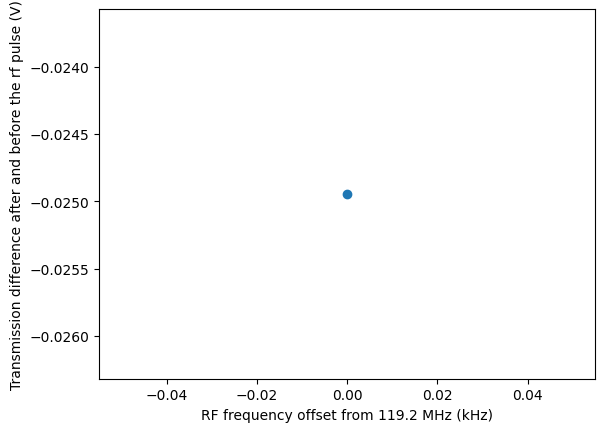

In [758]:
fig, ax = plt.subplots()
ax.plot(offsets_kHz, averages, marker="o", ls="none")
ax.set_xlabel("RF frequency offset from 119.2 MHz (kHz)")
ax.set_ylabel("Transmission difference after and before the rf pulse (V)")
plt.show()

In [759]:
index = 0
p = probes[index]
data_number = data_numbers[index]

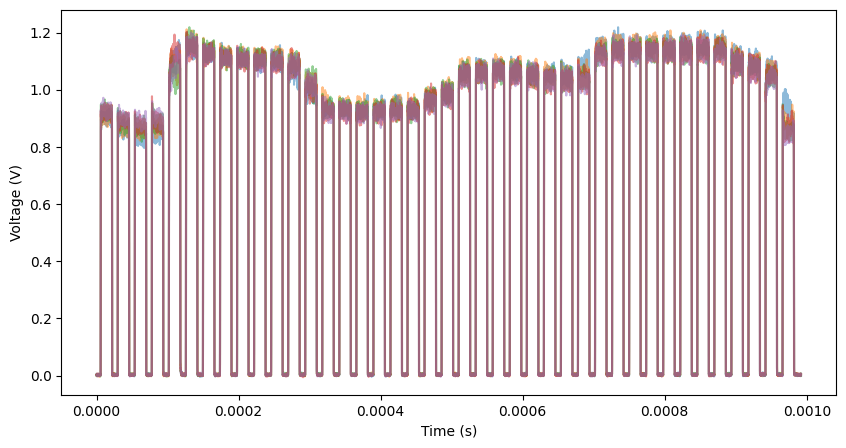

In [760]:
fig, ax = plt.subplots(figsize=(10, 5))
group_name = "initial"
reshape_size = (
    p.transmission_groups[group_name].shape[0] * p.transmission_groups[group_name].shape[1],
    p.transmission_groups[group_name].shape[2]
)
ax.plot(p.times, p.transmission_groups[group_name].reshape(*reshape_size)[:].T, alpha=0.5)
#ax.set_xlim(0, 0.00001)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (V)")
plt.show()

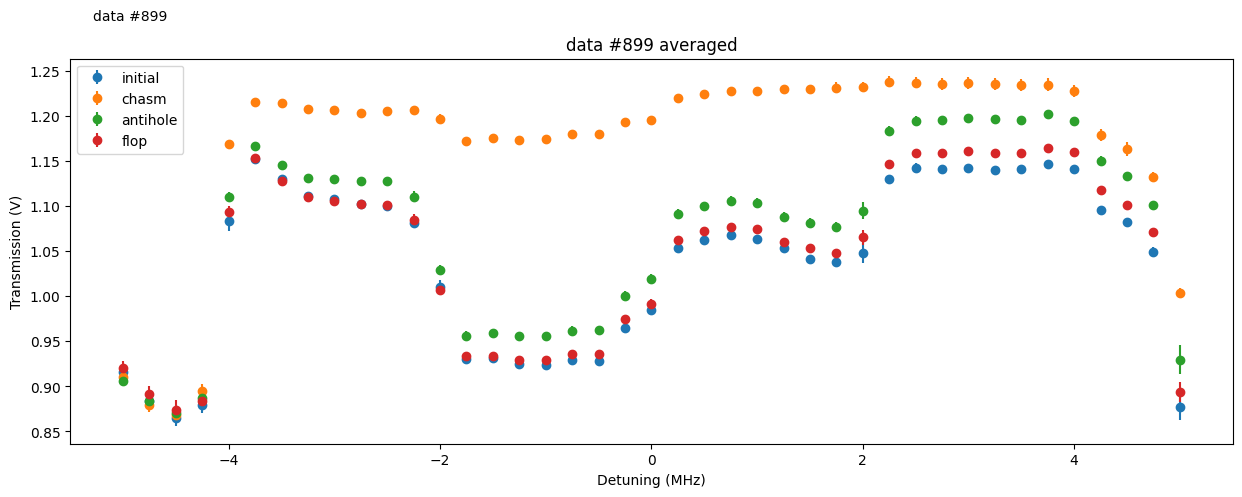

In [761]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
ax.errorbar(p.probes, p.averages("initial"), p.errors("initial"), label="initial", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("chasm"), p.errors("chasm"), label="chasm", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("antihole"), p.errors("antihole"), label="antihole", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("flop"), p.errors("flop"), label="flop", ls="none", marker="o")
ax.legend()
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.set_title(f"data #{data_number} averaged")
plt.show()

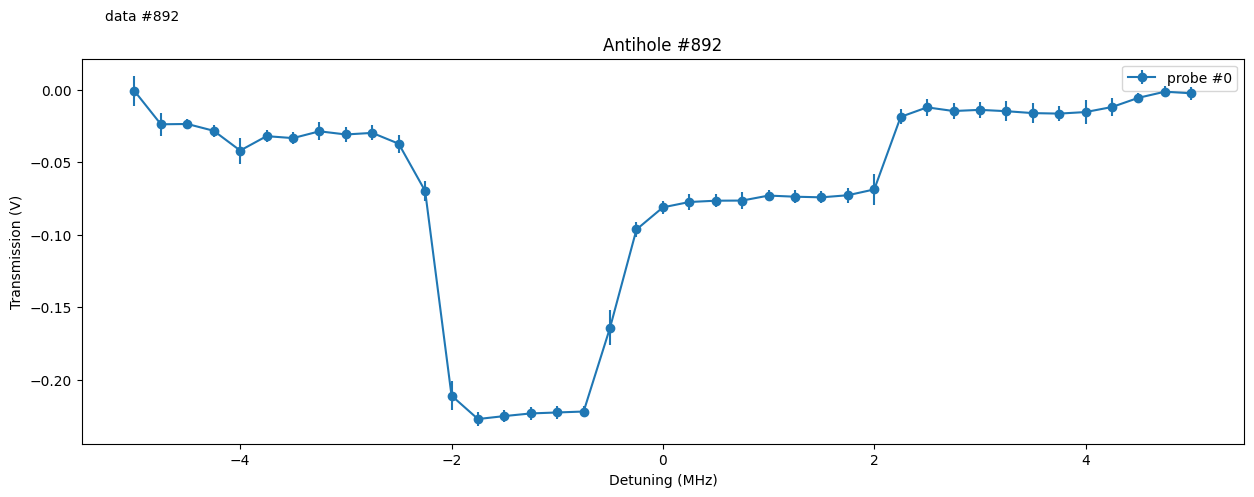

In [704]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
zorder = 100
for kk in range(len(p.averages("antihole_no_bg", mode="probe_repeats"))):
    signal = p.averages("antihole_no_bg", mode="probe_repeats")[kk]
    error = p.errors("antihole_no_bg", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
ax.legend()
ax.set_title(f"Antihole #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.show()

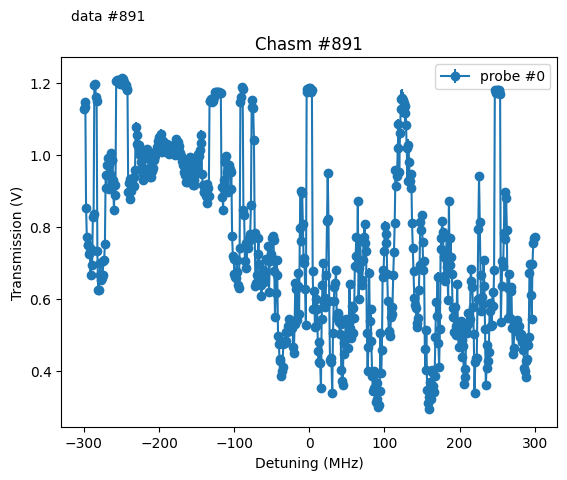

In [692]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
for kk in range(len(p.averages("chasm", mode="probe_repeats"))):
    signal = p.averages("chasm", mode="probe_repeats")[kk]
    error = p.errors("chasm", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
ax.legend()
ax.set_title(f"Chasm #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.show()

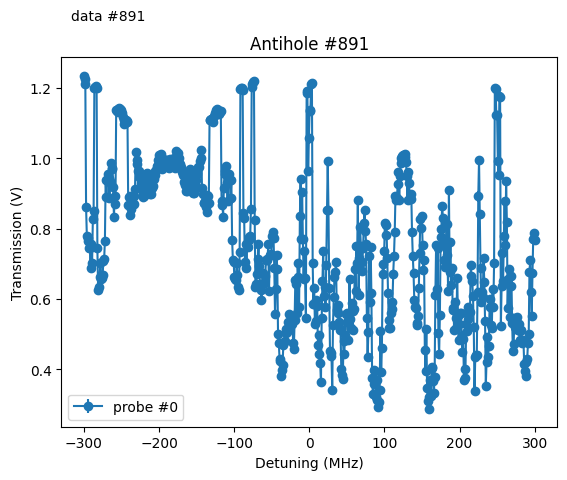

In [684]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
for kk in range(len(p.averages("antihole", mode="probe_repeats"))):
    signal = p.averages("antihole", mode="probe_repeats")[kk]
    error = p.errors("antihole", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
ax.legend()
ax.set_title(f"Antihole #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.show()

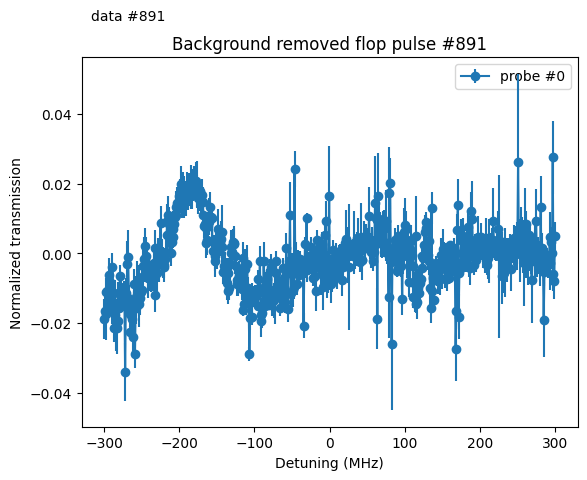

In [685]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
for kk in range(len(p.averages("flop_no_bg", mode="probe_repeats"))):
    signal = p.averages("flop_no_bg", mode="probe_repeats")[kk]
    error = p.errors("flop_no_bg", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
ax.legend()
ax.set_title(f"Background removed flop pulse #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

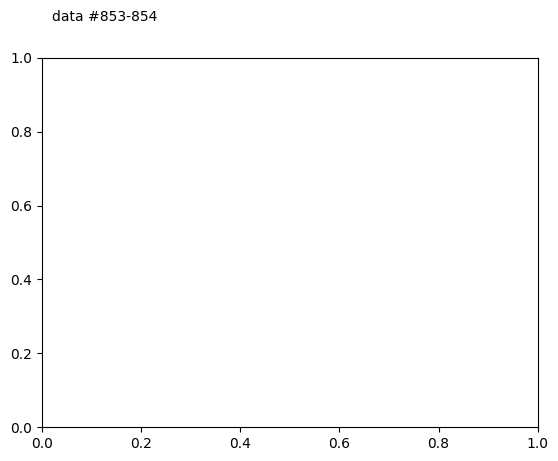

In [428]:
fig, ax = plt.subplots()
add_label(ax)
fit_amplitudes = []
fit_amplitude_errs = []
for kk, number in enumerate(data_numbers):
    probe = probes[kk]
    flop_time = flop_times_us[kk]
    index = 0
    signal = probe.normalized_averages("flop_no_bg")
    error = probe.normalized_errors("flop_no_bg")
    
    #fitter = Fitter(lorentzian)
    #fitter.set_p0({"amplitude": 0.01, "omega_0": 0, "gamma": 0.1, "floor": 0})
    fitter = Fitter(gaussian)
    fitter.set_p0({"amplitude": 0.01, "x_0": 0, "fwhm": 0.1, "floor": 0})
    fitter.set_data(probe.probes, signal, error)
    fitter.fit()
    fit_amplitudes.append(fitter.results["amplitude"])
    fit_amplitude_errs.append(fitter.errors["amplitude"])
    plt_freqs = np.linspace(min(probe.probes), max(probe.probes), 50)
    #print(kk)
    #print(fitter.all_results_str())
    
    ax.errorbar(probe.probes, signal, error, label=f"data #{number}, {flop_time:.1f} us flop time", ls="none", marker="o", color=f"C{kk}")
    ax.plot(plt_freqs, fitter.fitted_value(plt_freqs), color=f"C{kk}")
ax.legend()
ax.set_title("Background removed flop pulse")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Voltage (V)")
plt.show()

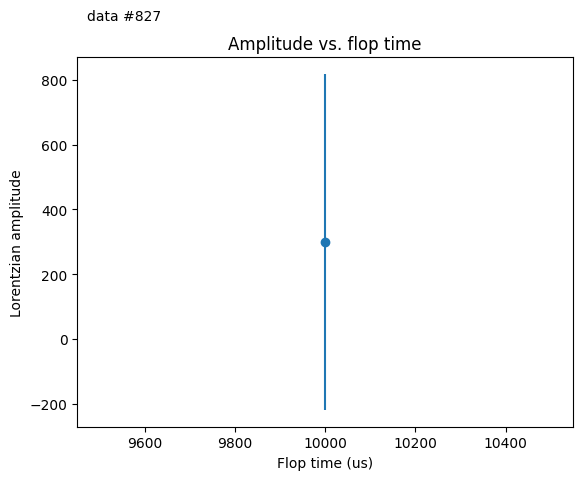

In [289]:
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(flop_times_us, fit_amplitudes, fit_amplitude_errs, marker="o", ls="none")
ax.set_title("Amplitude vs. flop time")
ax.set_xlabel("Flop time (us)")
ax.set_ylabel("Lorentzian amplitude")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.show()